In [1]:
import numpy as np
from hamiltonians import *
from helpers import *
from qite_params import QITE_params

In [2]:
def get_submatrix(H, term):
    nbits = H.nbits
    nops = 2**nbits
    h_mat = np.zeros((nops,nops), dtype=complex)
    hm = H.hm_list[term]
    if nbits == 1:
        for i in range(len(hm[0])):
            h_mat += hm[1][i] * sigma_matrices[hm[0][i]]
    else:
        active = [H.map[hm[2][i]] for i in range(len(hm[2]))]
        nactive = len(active)
        nterms = len(hm[0])
        for i in range(nterms):
            full_pauli_str = [0] * nbits
            partial_pauli_str = int_to_base(hm[0][i],4,nactive)
            for j in range(nactive):
                full_pauli_str[active[j]] = partial_pauli_str[j]
            # reverse the string to be consistend with Qiskit's qubit ordering
            full_pauli_str = full_pauli_str[::-1]
            # The matrix for the term is a tensor product of the corresponding Pauli matrices
            term_matrix = sigma_matrices[full_pauli_str[0]]
            for j in range(1,nbits):
                term_matrix = np.kron(term_matrix, sigma_matrices[full_pauli_str[j]])
            # Scale by the coefficient of the term
            term_matrix *= hm[1][i]

            # Add the term to the final matrix
            h_mat += term_matrix
    return h_mat

In [181]:
import time

TOLERANCE = 1e-8

def exp_mat_psi(mat, psi):
    chi = psi.copy()
    phi = psi.copy()
    i = 1
    while np.linalg.norm(chi) > TOLERANCE:
        chi = 1/i * (mat @ chi)
        phi += chi
        i += 1
    return phi

def get_delta0(H: Hamiltonian, term, psi0):
    d0 = exp_mat_psi(get_submatrix(H, term) * db, psi0)
    c = np.linalg.norm(d0)
    d0 /= c
    d0 -= psi0
    d0 /= db
    return d0

def update_alist(H: Hamiltonian, term, psi0):  
    hm = H.hm_list[term]
    h_mat = get_submatrix(H, term)
    nbits = H.nbits
    active = hm[2]
    nactive = len(hm[2])
    nops = 4**nactive
    
    S = np.eye(nops, dtype=complex)
    b = np.zeros(nops, dtype=complex)
    for i in range(nops):
        for j in range(i):
            p_, c_ = pauli_string_prod(i, j, nactive)
            partial_pstring = int_to_base(p_, 4, nactive)
            full_pstring = [0] * nbits
            for k in range(nactive):
                full_pstring[active[k]] = partial_pstring[k]
            p_mat = sigma_matrices[full_pstring[0]]
            for k in range(1,nbits):
                p_mat = np.kron(sigma_matrices[full_pstring[k]], p_mat)
            
            S[i,j] = np.vdot(psi0, p_mat@psi0) * c_
            S[j,i] = S[i,j].conjugate()
    
    psi_prime = exp_mat_psi(get_submatrix(H, term)*db, psi0)
    c = np.linalg.norm(psi_prime)
    for i in range(nops):
        partial_pstring = int_to_base(i, 4, nactive)
        full_pstring = [0] * nbits
        for k in range(nactive):
            full_pstring[active[k]] = partial_pstring[k]
        p_mat = sigma_matrices[full_pstring[0]]
        for k in range(1,nbits):
            p_mat = np.kron(sigma_matrices[full_pstring[k]], p_mat)
        b[i] = -2/(db*c) * np.imag( np.vdot(psi0, p_mat @ psi_prime) )
    
    a = np.linalg.lstsq( 2*np.real(S), b, rcond=-1 )[0]
    
    return a, S, b

def qite_step(H:Hamiltonian, psi0):
    alist = []
    slist = []
    blist = []
    psi = psi0.copy()
    nbits = H.nbits
    for term in range(H.num_terms):
        a,S,b = update_alist(H, term, psi)
        alist.append(a)
        slist.append(S)
        blist.append(b)
        
        #update the state
        hm = H.hm_list[term]
        active = hm[2]
        nactive = len(active)
        nops = 4**nactive
        A = np.zeros((2**nbits, 2**nbits), dtype=complex)
        for i in range(nops):
            partial_pstring = int_to_base(i, 4, nactive)
            full_pstring = [0] * nbits
            for k in range(nactive):
                full_pstring[active[k]] = partial_pstring[k]
            p_mat = sigma_matrices[full_pstring[0]]
            for k in range(1,nbits):
                p_mat = np.kron(sigma_matrices[full_pstring[k]], p_mat)
            A += a[i] * p_mat
        psi = exp_mat_psi(-1j*A*db, psi)
    
    return alist, slist, blist, psi

import time
def qite(H:Hamiltonian, psi0, N):
    alist = []
    slist = []
    blist = []
    svs = np.zeros((N+1,psi0.shape[0]), dtype=complex)
    svs[0,:] = psi0
    for i in range(1,N+1):
        print('Iteration {}...'.format(i),end=' ', flush=True)
        t0 = time.time()
        n_a, n_s, n_b, phi = qite_step(H, svs[i-1])
        alist += n_a
        slist += n_s
        blist += n_b
        svs[i,:] = phi
        t1 = time.time()
        duration = t1-t0
        print('Done -- Iteration time = {:0.2f} {}'.format(duration if duration < 60 else duration/60, 'seconds' if duration < 60 else 'minutes'))
    return alist, slist, blist, svs

[[-0.14766112-0.28762891j -0.53881988+1.09057184j]
 [ 0.46353838-0.21695281j -0.10617483-1.24326082j]]
Performing Hamiltonian precalculations...
	Calculating Unitary Domains... Done
	Calculating Required Pauli Measurements... Done
Iteration 1... Done -- Iteration time = 0.00 seconds
Iteration 2... Done -- Iteration time = 0.00 seconds
Iteration 3... Done -- Iteration time = 0.00 seconds
Iteration 4... Done -- Iteration time = 0.00 seconds
Iteration 5... Done -- Iteration time = 0.00 seconds
Iteration 6... Done -- Iteration time = 0.00 seconds
Iteration 7... Done -- Iteration time = 0.00 seconds
Iteration 8... Done -- Iteration time = 0.00 seconds
Iteration 9... Done -- Iteration time = 0.00 seconds
Iteration 10... Done -- Iteration time = 0.00 seconds
Iteration 11... Done -- Iteration time = 0.00 seconds
Iteration 12... Done -- Iteration time = 0.00 seconds
Iteration 13... Done -- Iteration time = 0.00 seconds
Iteration 14... Done -- Iteration time = 0.00 seconds
Iteration 15... Done -

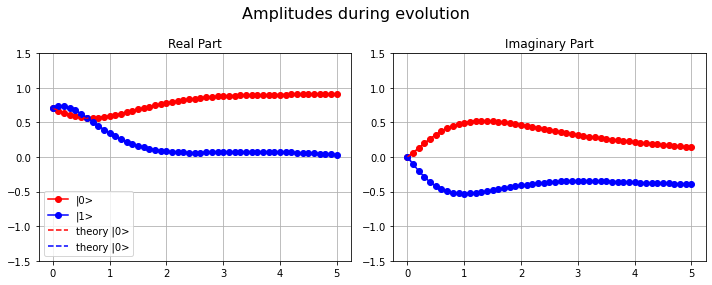

In [214]:
hm_list = [
    [ [0,1,2,3], np.random.uniform(-1.0,1.0,4) + 1j*np.random.uniform(-1.0,1.0,4), [0] ]
]
d = 1
l = 1
H = Hamiltonian(hm_list, d, l)
H_mat = H.get_matrix()
print(H_mat)

db = 0.1
delta = 0.0
N = 50
D = 0
nbits = H.nbits

# psi0 = np.array([1,0], dtype=complex)
psi0 = np.array([1,1], dtype=complex)*np.sqrt(0.5)

params = QITE_params(H)
params.load_hamiltonian_params(D, False)
params.set_run_params(db, delta, N, None, None, init_sv = psi0)

alist, slist, blist, svs = qite(H, psi0, N)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10,4))
axs = [f.add_subplot(121), f.add_subplot(122)]
t = np.arange(0,N+1,1)*db
re = np.real(svs)
im = np.imag(svs)

theory = np.zeros( (N+1,2), dtype=complex )
for i in range(N+1):
    v = exp_mat_psi(H.get_matrix() * i*db, psi0)
    theory[i,:] = v/np.linalg.norm(v)

axs[0].plot(t,re[:,0],'ro-', label='|0>')
axs[0].plot(t,re[:,1],'bo-', label='|1>')

axs[0].plot(t, np.real(theory[:,0]), 'r--', label='theory |0>' )
axs[0].plot(t, np.real(theory[:,1]), 'b--', label='theory |0>' )

axs[1].plot(t,im[:,0],'ro-', label='|0>')
axs[1].plot(t,im[:,1],'bo-', label='|1>')

axs[1].plot(t, np.imag(theory[:,0]), 'r--', label='theory |0>' )
axs[1].plot(t, np.imag(theory[:,1]), 'b--', label='theory |0>' )

axs[0].set_ylim(-1.5,1.5)
axs[1].set_ylim(-1.5,1.5)

axs[0].title.set_text('Real Part')
axs[1].title.set_text('Imaginary Part')


axs[0].legend(loc='best')

axs[0].grid()
axs[1].grid()

f.suptitle('Amplitudes during evolution', fontsize=16)
f.tight_layout()
plt.show()
# f.savefig('numerial X+iZ on +.png')